
# Tower A 2D Demo v3

Version 3 blends the step-by-step walkthrough from v1 with the stronger sampling, adaptive refinement, and PINA best-practices from v2. The `Equation` usage matches the guidance in `PINA-master/tutorials/tutorial12` so we keep pace with upstream API changes.



**Workflow**
- Build a high-resolution finite-difference (FD) reference on the symmetric 12 mm x 12 mm domain.
- Define the PINN with oversampled PDE regions, Neumann/Dirichlet enforcement, and a symmetry plane to avoid the flat "bar" artefact.
- Train in two stages (baseline + residual-adaptive refinement) similar to MATLAB scripts: configure constants up front, then call helper functions in sequence.
- Compare FD and PINN maps/sections with compact plotting helpers.


In [1]:

import os
from dataclasses import dataclass
from types import SimpleNamespace
from typing import Dict, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch._dynamo

from pina import Condition, LabelTensor
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue, Laplace
from pina.model import FeedForward
from pina.operator import grad, laplacian
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer
from lightning.pytorch.callbacks import EarlyStopping

torch._dynamo.config.disable = True
torch._dynamo.config.suppress_errors = True
os.environ.setdefault("TORCH_COMPILE_DISABLE", "1")

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "image.origin": "lower",
    "axes.grid": False,
    "font.size": 12,
})

torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda")
    print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend (Metal).")
else:
    device = torch.device("cpu")
    print("Using CPU.")


def trainer_device_kwargs() -> Dict[str, object]:
    if torch.cuda.is_available():
        return {"accelerator": "cuda", "devices": 1}
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return {"accelerator": "mps", "devices": 1}
    return {"accelerator": "cpu", "devices": 1}


Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)


In [15]:

CONFIG = SimpleNamespace(
    geometry=SimpleNamespace(
        width_mm=12.0,
        depth_mm=12.0,
        electrode_center_mm=0.0,
        electrode_halfwidth_mm=0.025,
        gauge_halfwidth_mm=1.5,
    ),
    grid=SimpleNamespace(
        Nx=721,
        Nz=721,
    ),
    training=SimpleNamespace(
        interior_points=10_000,
        dirichlet_points=1_200,
        neumann_points=1_000,
        interior_boost=3,
        dirichlet_boost=6,
        conductivity_S_per_mm=1.0,
        phi_electrode=1.0,
        phi_gauge=0.0,
        hidden_size=64,
        n_layers=6,
        activation=nn.SiLU,
        normalize_inputs=True,
        max_epochs_stage1=200,
        max_epochs_stage2=200,
        rar_points=20_000,
        rar_cand_factor=10,
        early_stop_patience=200,
        early_stop_min_delta=1e-5,
    ),
)

geom = CONFIG.geometry
grid = CONFIG.grid

x_min, x_max = -geom.width_mm / 2, geom.width_mm / 2
z_min, z_max = 0.0, geom.depth_mm

x = np.linspace(x_min, x_max, grid.Nx)
z = np.linspace(z_min, z_max, grid.Nz)
dx = float(x[1] - x[0])
dz = float(z[1] - z[0])
X, Z = np.meshgrid(x, z, indexing="ij")


def make_bottom_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    return np.abs(x - center_mm) <= half_width_mm


electrode_mask = make_bottom_mask(geom.electrode_center_mm, geom.electrode_halfwidth_mm)
gauge_mask = np.abs(x) <= geom.gauge_halfwidth_mm

print(f"Grid spacing: dx = {dx:.4f} mm, dz = {dz:.4f} mm")
print(f"Electrode nodes at z=0 mm: {electrode_mask.sum()}")
print(f"Gauge nodes at z={z_max} mm: {gauge_mask.sum()}")


Grid spacing: dx = 0.0167 mm, dz = 0.0167 mm
Electrode nodes at z=0 mm: 3
Gauge nodes at z=12.0 mm: 181



## Finite-difference reference (baseline for the PINN)


In [3]:

def solve_laplace_fd(
    electrode_mask: np.ndarray,
    *,
    phi_electrode: float,
    phi_gauge: float,
    gauge_mask: np.ndarray,
    max_iters: int = 8_000,
    tol: float = 1e-5,
    verbose: bool = False,
) -> np.ndarray:
    """Jacobi relaxation for Laplace's equation with mixed BCs."""
    phi = np.zeros((grid.Nx, grid.Nz), dtype=np.float64)
    electrode_idx = electrode_mask.astype(bool)
    gauge_idx = gauge_mask.astype(bool)

    for it in range(max_iters):
        phi_old = phi.copy()
        phi[1:-1, 1:-1] = 0.25 * (
            phi_old[2:, 1:-1] + phi_old[:-2, 1:-1] +
            phi_old[1:-1, 2:] + phi_old[1:-1, :-2]
        )

        phi[~electrode_idx, 0] = phi[~electrode_idx, 1]
        phi[electrode_idx, 0] = phi_electrode

        phi[~gauge_idx, -1] = phi[~gauge_idx, -2]
        phi[gauge_idx, -1] = phi_gauge

        phi[0, :] = phi[1, :]
        phi[-1, :] = phi[-2, :]

        err = float(np.max(np.abs(phi - phi_old)))
        if verbose and it % 500 == 0:
            print(f"iter {it:5d}, max dphi = {err:.3e}")
        if err < tol:
            if verbose:
                print(f"Converged in {it} iterations with max dphi = {err:.3e}")
            break
    return phi


def compute_field(phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dphi_dx = np.zeros_like(phi)
    dphi_dz = np.zeros_like(phi)

    dphi_dx[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    dphi_dx[0, :] = (phi[1, :] - phi[0, :]) / dx
    dphi_dx[-1, :] = (phi[-1, :] - phi[-2, :]) / dx

    dphi_dz[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dz)
    dphi_dz[:, 0] = (phi[:, 1] - phi[:, 0]) / dz
    dphi_dz[:, -1] = (phi[:, -1] - phi[:, -2]) / dz

    Ex = -dphi_dx
    Ez = -dphi_dz
    Emag = np.sqrt(Ex**2 + Ez**2)
    return Ex, Ez, Emag


def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    quiver_step: int = 18,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
) -> None:
    vmax = float(vmax) if vmax is not None else float(np.quantile(Emag, 0.995))
    fig, ax = plt.subplots(figsize=(7, 5))
    img = ax.imshow(
        Emag.T,
        extent=[x_min, x_max, z_min, z_max],
        cmap=cmap,
        origin="lower",
        aspect="equal",
        vmin=0.0,
        vmax=vmax,
    )
    fig.colorbar(img, ax=ax, label="|E| (arb. units)")

    Xs = X[::quiver_step, ::quiver_step]
    Zs = Z[::quiver_step, ::quiver_step]
    Exs = Ex[::quiver_step, ::quiver_step]
    Ezs = Ez[::quiver_step, ::quiver_step]
    ax.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        angles="xy",
        scale_units="xy",
        scale=40 * vmax,
        width=0.002,
    )

    ax.plot(
        x[electrode_mask],
        np.full(np.count_nonzero(electrode_mask), z_min),
        "c",
        lw=3,
        label="Electrode (phi=1 V)",
    )
    ax.plot(
        x[gauge_mask],
        np.full(np.count_nonzero(gauge_mask), z_max),
        "w",
        lw=3,
        label="Gauge (phi=0 V)",
    )
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("z (mm)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


def plot_centerline_profiles(phi_map: np.ndarray, label: str, color: Optional[str] = None) -> None:
    ix0 = np.argmin(np.abs(x - 0.0))
    plt.plot(z, phi_map[ix0], label=label, color=color)


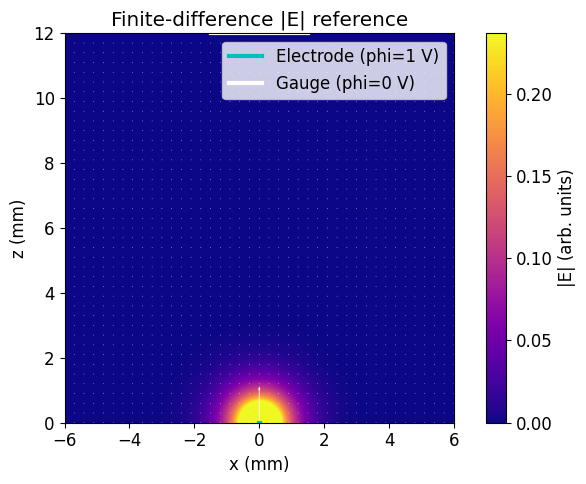

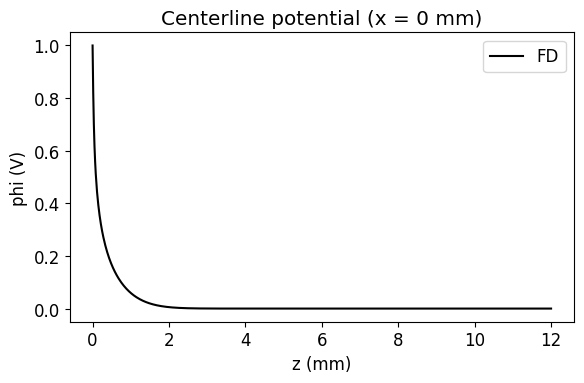

In [4]:

phi_fd = solve_laplace_fd(
    electrode_mask,
    phi_electrode=CONFIG.training.phi_electrode,
    phi_gauge=CONFIG.training.phi_gauge,
    gauge_mask=gauge_mask,
    verbose=False,
)
Ex_fd, Ez_fd, Emag_fd = compute_field(phi_fd)
plot_field_map(Emag_fd, Ex_fd, Ez_fd, title="Finite-difference |E| reference")

plt.figure(figsize=(6, 4))
plot_centerline_profiles(phi_fd, label="FD", color="k")
plt.xlabel("z (mm)")
plt.ylabel("phi (V)")
plt.title("Centerline potential (x = 0 mm)")
plt.legend()
plt.tight_layout()
plt.show()



## PINN setup (PINA-based)


In [16]:

@dataclass(frozen=True)
class TowerA2DGeometry:
    x_bounds: Tuple[float, float]
    z_bounds: Tuple[float, float]
    electrode_center_mm: float
    electrode_halfwidth_mm: float
    gauge_halfwidth_mm: float

    @property
    def electrode_span(self) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], self.electrode_center_mm - self.electrode_halfwidth_mm)
        hi = min(self.x_bounds[1], self.electrode_center_mm + self.electrode_halfwidth_mm)
        return float(lo), float(hi)

    @property
    def gauge_span(self) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], -self.gauge_halfwidth_mm)
        hi = min(self.x_bounds[1], self.gauge_halfwidth_mm)
        return float(lo), float(hi)


@dataclass(frozen=True)
class NeumannSegment:
    name: str
    axis: str
    normal_sign: int


def build_neumann_equation(
    axis: str,
    normal_sign: int,
    conductivity: float,
    axes: Sequence[str] = ("x", "z"),
) -> Equation:
    axis_index = list(axes).index(axis)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        component = grad_phi[:, axis_index]
        flux = -conductivity * normal_sign * component
        target = torch.zeros_like(flux)
        return LabelTensor((flux - target).unsqueeze(-1), labels=["flux"])

    return Equation(residual)


def build_symmetry_equation(axis: str = "x") -> Equation:
    axis_index = 0 if axis == "x" else 1

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=["x", "z"]).tensor
        component = grad_phi[:, axis_index]
        return LabelTensor(component.unsqueeze(-1), labels=["symmetry_grad"])

    return Equation(residual)


In [17]:

class TowerA2DProblem(SpatialProblem):
    output_variables = ["phi"]
    axes = ("x", "z")

    def __init__(self, geometry: TowerA2DGeometry, conductivity: float):
        self.geometry = geometry
        self.conductivity = float(conductivity)
        self.domains, self.neumann_segments, self.dirichlet_domains = self._build_domains()
        self._spatial_domain = self.domains["interior"]
        self._conditions = self._build_conditions()
        super().__init__()

    def _build_domains(self):
        domains: Dict[str, CartesianDomain] = {}
        x_bounds = list(self.geometry.x_bounds)
        z_bounds = list(self.geometry.z_bounds)
        domains["interior"] = CartesianDomain({"x": x_bounds, "z": z_bounds})

        band_h = 1.0
        domains["interior_bottom_band"] = CartesianDomain({"x": x_bounds, "z": [z_bounds[0], z_bounds[0] + band_h]})
        domains["interior_top_band"] = CartesianDomain({"x": x_bounds, "z": [z_bounds[1] - band_h, z_bounds[1]]})

        margin_x = 1.0
        elec_lo, elec_hi = self.geometry.electrode_span
        domains["interior_bottom_core"] = CartesianDomain({
            "x": [max(x_bounds[0], elec_lo - margin_x), min(x_bounds[1], elec_hi + margin_x)],
            "z": [z_bounds[0], z_bounds[0] + 1.5],
        })

        g_lo, g_hi = self.geometry.gauge_span
        domains["interior_top_core"] = CartesianDomain({
            "x": [max(x_bounds[0], g_lo - margin_x), min(x_bounds[1], g_hi + margin_x)],
            "z": [z_bounds[1] - 1.5, z_bounds[1]],
        })

        dirichlet_domains: list[str] = []
        domains["electrode_bc"] = CartesianDomain({"x": [elec_lo, elec_hi], "z": z_bounds[0]})
        dirichlet_domains.append("electrode_bc")
        domains["gauge_bc"] = CartesianDomain({"x": [g_lo, g_hi], "z": z_bounds[1]})
        dirichlet_domains.append("gauge_bc")

        domains["symmetry_plane"] = CartesianDomain({"x": 0.0, "z": z_bounds})

        neumann_segments: list[NeumannSegment] = []
        x_min_loc, x_max_loc = self.geometry.x_bounds
        z_min_loc, z_max_loc = self.geometry.z_bounds

        def add_segment(name: str, *, x_range=None, z_range=None, const_x=None, const_z=None, axis="z", normal_sign=1):
            payload = {}
            payload["x"] = float(const_x) if const_x is not None else [float(x_range[0]), float(x_range[1])]
            payload["z"] = float(const_z) if const_z is not None else [float(z_range[0]), float(z_range[1])]
            domains[name] = CartesianDomain(payload)
            neumann_segments.append(NeumannSegment(name=name, axis=axis, normal_sign=normal_sign))

        
        # replace eps offset with exact boundaries, and exclude the Dirichlet spans
        add_segment("bottom_left",  x_range=(x_min_loc, elec_lo),
                    const_z=z_min_loc, axis="z", normal_sign=-1)
        add_segment("bottom_right", x_range=(elec_hi, x_max_loc),
                    const_z=z_min_loc, axis="z", normal_sign=-1)

        add_segment("top_left",     x_range=(x_min_loc, g_lo),
                    const_z=z_max_loc, axis="z", normal_sign=+1)
        add_segment("top_right",    x_range=(g_hi, x_max_loc),
                    const_z=z_max_loc, axis="z", normal_sign=+1)

        add_segment("left_wall", const_x=x_min_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=-1)
        add_segment("right_wall", const_x=x_max_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=1)

        return domains, neumann_segments, dirichlet_domains

    def _build_conditions(self) -> Dict[str, Condition]:
        conditions: Dict[str, Condition] = {}
        laplace_axes = list(self.axes)
        conditions["pde"] = Condition(domain="interior", equation=Laplace(components=["phi"], d=laplace_axes))
        conditions["pde_bottom_band"] = Condition(domain="interior_bottom_band", equation=Laplace(components=["phi"], d=laplace_axes))
        conditions["pde_bottom_core"] = Condition(domain="interior_bottom_core", equation=Laplace(components=["phi"], d=laplace_axes))
        conditions["pde_top_band"] = Condition(domain="interior_top_band", equation=Laplace(components=["phi"], d=laplace_axes))
        conditions["pde_top_core"] = Condition(domain="interior_top_core", equation=Laplace(components=["phi"], d=laplace_axes))

        conditions["electrode"] = Condition(domain="electrode_bc", equation=FixedValue(1.0, components=["phi"]))
        conditions["gauge"] = Condition(domain="gauge_bc", equation=FixedValue(0.0, components=["phi"]))
        conditions["symmetry"] = Condition(domain="symmetry_plane", equation=build_symmetry_equation("x"))

        for seg in self.neumann_segments:
            eq = build_neumann_equation(seg.axis, seg.normal_sign, self.conductivity, axes=self.axes)
            conditions[f"neumann:{seg.name}"] = Condition(domain=seg.name, equation=eq)
        return conditions

    @property
    def spatial_domain(self):
        return self._spatial_domain

    @property
    def conditions(self) -> Dict[str, Condition]:
        return self._conditions


def boost_domain_samples(problem: TowerA2DProblem, domain_name: str, factor: int) -> None:
    if factor <= 1:
        return
    lt = problem.discretised_domains.get(domain_name)
    if lt is None:
        return
    tensors = [lt.tensor.clone() for _ in range(factor)]
    problem.discretised_domains[domain_name] = LabelTensor(torch.cat(tensors, dim=0), labels=lt.labels)


def discretise_problem(problem: TowerA2DProblem, cfg: SimpleNamespace) -> None:
    n_int = cfg.interior_points
    problem.discretise_domain(n=n_int, mode="latin", domains="interior")
    problem.discretise_domain(n=2 * n_int, mode="latin", domains="interior_bottom_band")
    problem.discretise_domain(n=3 * n_int, mode="latin", domains="interior_bottom_core")
    problem.discretise_domain(n=2 * n_int, mode="latin", domains="interior_top_band")
    problem.discretise_domain(n=3 * n_int, mode="latin", domains="interior_top_core")

    for name in problem.dirichlet_domains:
        problem.discretise_domain(n=cfg.dirichlet_points, mode="random", domains=name)
    for seg in problem.neumann_segments:
        problem.discretise_domain(n=cfg.neumann_points, mode="random", domains=seg.name)
    problem.discretise_domain(n=cfg.neumann_points, mode="random", domains="symmetry_plane")

    boost_domain_samples(problem, "interior", cfg.interior_boost)
    boost_domain_samples(problem, "interior_bottom_band", max(1, cfg.interior_boost // 2))
    for name in problem.dirichlet_domains:
        boost_domain_samples(problem, name, cfg.dirichlet_boost)


class LabelTensorAffineNormalizer(nn.Module):
    def __init__(self, axes: Sequence[str], shift: Sequence[float], scale: Sequence[float]):
        super().__init__()
        self.axes = list(axes)
        self.register_buffer("shift", torch.tensor(shift, dtype=torch.float32).view(1, -1))
        self.register_buffer("scale", torch.tensor(scale, dtype=torch.float32).view(1, -1))

    def forward(self, lt: LabelTensor) -> LabelTensor:
        shift = self.shift
        scale = self.scale
        if shift.device != lt.tensor.device:
            shift = shift.to(lt.tensor.device)
            scale = scale.to(lt.tensor.device)
        tensor = (lt.tensor - shift) * scale
        return LabelTensor(tensor, labels=list(lt.labels))


def build_model(hidden_size: int, n_layers: int, activation: type[nn.Module], normalizer: Optional[nn.Module]) -> nn.Module:
    core = FeedForward(
        input_dimensions=2,
        output_dimensions=1,
        inner_size=hidden_size,
        n_layers=n_layers,
        func=activation,
    )
    if normalizer is not None:
        return nn.Sequential(normalizer, core)
    return core


def fine_tune_trainer(solver, *, max_epochs: int, lr_factor: float, **trainer_kwargs):
    for group in solver.optimizer.instance.param_groups:
        group["lr"] = group["lr"] * lr_factor
    trainer = Trainer(solver=solver, max_epochs=max_epochs, **trainer_kwargs)
    trainer.train()
    return trainer


def add_rar_points(problem: TowerA2DProblem, solver, n_new: int, cand_factor: int) -> None:
    solver.eval()
    dev = next(solver.parameters()).device

    n_cand = cand_factor * n_new
    cand = problem.domains["interior"].sample(n_cand, mode="random")
    cand_t = cand.tensor.to(dev).detach().requires_grad_(True)
    cand = LabelTensor(cand_t, labels=cand.labels)

    with torch.enable_grad():
        out = solver(cand)
        lap = laplacian(out, cand, components=["phi"], d=["x", "z"]).tensor
        res = lap.abs().view(-1)

    k = min(n_new, res.numel())
    idx = torch.topk(res, k=k).indices
    rar = LabelTensor(cand.tensor[idx].detach().cpu(), labels=cand.labels)

    old = problem.discretised_domains["interior"]
    problem.discretised_domains["interior"] = LabelTensor(
        torch.cat([old.tensor, rar.tensor], dim=0),
        labels=old.labels,
    )


def train_tower_a_pinn(config: SimpleNamespace) -> Dict[str, object]:
    geom_cfg = config.geometry
    train_cfg = config.training
    geometry = TowerA2DGeometry(
        x_bounds=(x_min, x_max),
        z_bounds=(z_min, z_max),
        electrode_center_mm=geom_cfg.electrode_center_mm,
        electrode_halfwidth_mm=geom_cfg.electrode_halfwidth_mm,
        gauge_halfwidth_mm=geom_cfg.gauge_halfwidth_mm,
    )
    problem = TowerA2DProblem(geometry=geometry, conductivity=train_cfg.conductivity_S_per_mm)
    discretise_problem(problem, train_cfg)

    normalizer: Optional[nn.Module] = None
    if train_cfg.normalize_inputs:
        margin = 0.90
        x_shift = sum(geometry.x_bounds) * 0.5
        z_shift = sum(geometry.z_bounds) * 0.5
        x_scale = (2.0 * margin) / (geometry.x_bounds[1] - geometry.x_bounds[0])
        z_scale = (2.0 * margin) / (geometry.z_bounds[1] - geometry.z_bounds[0])
        normalizer = LabelTensorAffineNormalizer(("x", "z"), (x_shift, z_shift), (x_scale, z_scale))

    callbacks = []
    if train_cfg.early_stop_patience and train_cfg.early_stop_patience > 0:
        callbacks.append(
            EarlyStopping(
                monitor="train_loss",
                patience=train_cfg.early_stop_patience,
                min_delta=train_cfg.early_stop_min_delta,
                mode="min",
                check_finite=True,
            )
        )

    model = build_model(
        hidden_size=train_cfg.hidden_size,
        n_layers=train_cfg.n_layers,
        activation=train_cfg.activation,
        normalizer=normalizer,
    ).to(device)

    solver = PINN(problem=problem, model=model)
    trainer = Trainer(
        solver=solver,
        max_epochs=train_cfg.max_epochs_stage1,
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
        accelerator=trainer_device_kwargs()["accelerator"],
        devices=trainer_device_kwargs()["devices"],
        callbacks=callbacks or None,
    )
    trainer.train()

    add_rar_points(problem, solver, n_new=train_cfg.rar_points, cand_factor=train_cfg.rar_cand_factor)
    fine_tune_trainer(
        solver,
        max_epochs=train_cfg.max_epochs_stage2,
        lr_factor=0.25,
        accelerator=trainer_device_kwargs()["accelerator"],
        devices=trainer_device_kwargs()["devices"],
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
    )

    return {
        "geometry": geometry,
        "problem": problem,
        "model": model,
        "solver": solver,
    }


In [ ]:

def _device_of_model(model: nn.Module) -> torch.device:
    for p in model.parameters():
        return p.device
    for b in model.buffers():
        return b.device
    return torch.device("cpu")


def _extract_phi_tensor(outputs: object) -> torch.Tensor:
    if hasattr(outputs, "extract"):
        try:
            extracted = outputs.extract(["phi"]).tensor
        except Exception:
            extracted = getattr(outputs, "tensor", outputs)
    elif hasattr(outputs, "tensor"):
        extracted = outputs.tensor
    else:
        extracted = outputs
    if isinstance(extracted, torch.Tensor):
        if extracted.ndim == 2 and extracted.shape[-1] == 1:
            extracted = extracted.squeeze(-1)
        return extracted
    return torch.as_tensor(extracted)


def evaluate_model_on_grid(model: nn.Module, x_coords: np.ndarray = x, z_coords: np.ndarray = z) -> np.ndarray:
    model.eval()
    dev = _device_of_model(model)
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=dev)
    coords_lt = LabelTensor(coords_tensor, labels=["x", "z"])
    with torch.no_grad():
        outputs = model(coords_lt)
        phi_tensor = _extract_phi_tensor(outputs)
    return phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))


def compute_field_from_model(model: nn.Module, x_coords: np.ndarray = x, z_coords: np.ndarray = z):
    model.eval()
    dev = _device_of_model(model)
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=dev, requires_grad=True)
    coords_lt = LabelTensor(coords_tensor, labels=["x", "z"])
    outputs = model(coords_lt)
    phi_tensor = _extract_phi_tensor(outputs)
    grads = torch.autograd.grad(
        phi_tensor,
        coords_tensor,
        grad_outputs=torch.ones_like(phi_tensor, device=dev),
        create_graph=False,
        retain_graph=False,
    )[0]
    grad_x = grads[:, 0].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    grad_z = grads[:, 1].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    Ex = -grad_x
    Ez = -grad_z
    Emag = np.sqrt(Ex**2 + Ez**2)
    phi = phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    return phi, Ex, Ez, Emag


def compute_fd_metrics(phi_candidate: np.ndarray) -> Dict[str, float]:
    diff = phi_candidate - phi_fd
    rel_l2 = float(np.linalg.norm(diff) / np.linalg.norm(phi_fd))
    max_abs = float(np.max(np.abs(diff)))
    return {"diff": diff, "rel_l2": rel_l2, "max_abs": max_abs}


def compare_fd_to_pinn(phi_fd: np.ndarray, phi_pinn: np.ndarray) -> Dict[str, float]:
    metrics = compute_fd_metrics(phi_pinn)
    print(f"Relative L2 error = {metrics['rel_l2']:.3e}; max |phi diff| = {metrics['max_abs']:.3e}")
    plt.figure(figsize=(6, 4))
    plt.imshow(
        metrics["diff"].T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap="coolwarm",
        origin="lower",
    )
    plt.colorbar(label="phi_PINN - phi_FD")
    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.title("PINN vs FD potential difference")
    plt.tight_layout()
    plt.show()
    return metrics


def report_boundary_stats(phi_map: np.ndarray, label: str = "") -> Dict[str, float]:
    electrode_vals = phi_map[electrode_mask, 0]
    gauge_vals = phi_map[gauge_mask, -1]
    stats = {
        "electrode_mean": float(electrode_vals.mean()),
        "electrode_max_err": float(np.max(np.abs(electrode_vals - CONFIG.training.phi_electrode))),
        "gauge_mean": float(gauge_vals.mean()),
        "gauge_max_err": float(np.max(np.abs(gauge_vals - CONFIG.training.phi_gauge))),
    }
    if label:
        print(f"Boundary stats ({label}):")
    print(f"  electrode phi mean={stats['electrode_mean']:.3f}, max|err|={stats['electrode_max_err']:.3e}")
    print(f"  gauge phi mean={stats['gauge_mean']:.3f}, max|err|={stats['gauge_max_err']:.3e}")
    return stats


def laplacian_stats(solver, geometry: TowerA2DGeometry, n: int = 5_000):
    solver.eval()
    dev = next(solver.parameters()).device
    xs = np.random.uniform(geometry.x_bounds[0], geometry.x_bounds[1], size=(n, 1))
    zs = np.random.uniform(geometry.z_bounds[0], geometry.z_bounds[1], size=(n, 1))
    coords = torch.tensor(np.hstack([xs, zs]), dtype=torch.float32, device=dev, requires_grad=True)
    lt = LabelTensor(coords, labels=["x", "z"])
    out = solver(lt)
    lap = laplacian(out, lt, components=["phi"], d=["x", "z"]).tensor
    abs_res = lap.detach().abs().cpu().numpy().squeeze()
    return float(abs_res.mean()), float(np.percentile(abs_res, 95))


def summarize_samples(problem: TowerA2DProblem) -> None:
    print("Samples per domain:")
    for name, lt in problem.discretised_domains.items():
        print(f"  {name:>24s}: {len(lt.tensor):6d}")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
2

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode
---------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | eval
1 | _loss_fn     | MSELoss    | 0      | eval
---------------------------------------------------
21.1 K    Train

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Samples per domain:
                  interior:  50000
      interior_bottom_band:  20000
      interior_bottom_core:  30000
         interior_top_band:  20000
         interior_top_core:  30000
              electrode_bc:   7200
                  gauge_bc:   7200
               bottom_left:   1000
              bottom_right:   1000
                  top_left:   1000
                 top_right:   1000
                 left_wall:   1000
                right_wall:   1000
            symmetry_plane:   1000
Relative L2 error = 3.646e+01; max |phi diff| = 1.000e+00


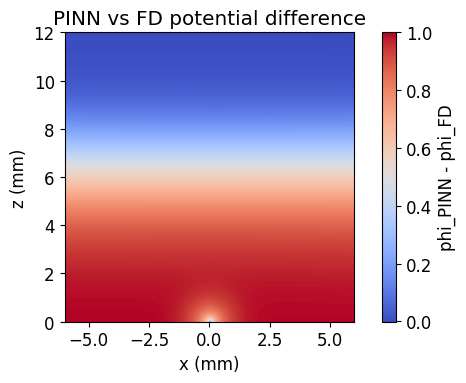

Boundary stats (PINN):
  electrode phi mean=0.999, max|err|=1.116e-03
  gauge phi mean=0.002, max|err|=2.012e-03


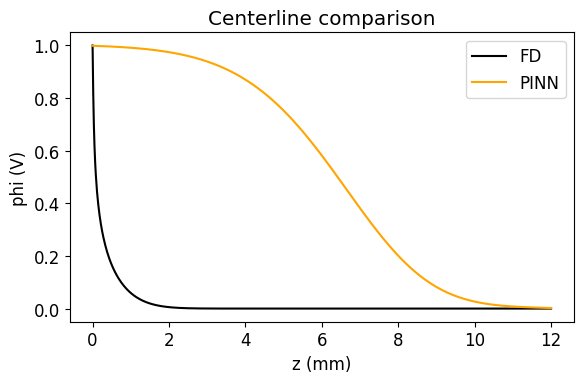

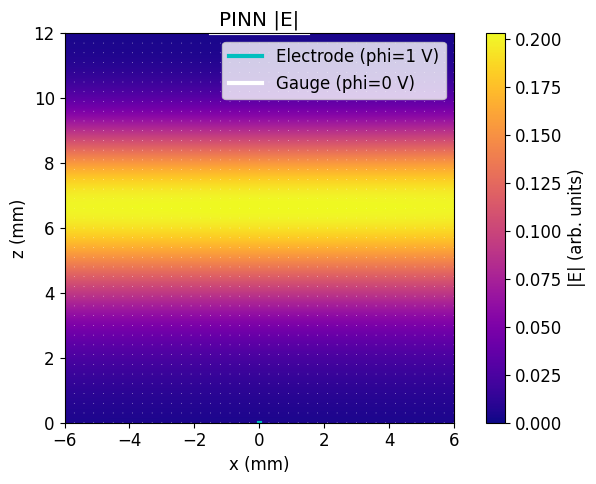

|laplacian(phi)| mean=3.27e-02, 95th%=6.89e-02


In [19]:

RUN_TRAINING = True

if RUN_TRAINING:
    run = train_tower_a_pinn(CONFIG)
    summarize_samples(run["problem"])

    phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(run["model"])
    compare_fd_to_pinn(phi_fd, phi_pinn)
    report_boundary_stats(phi_pinn, label="PINN")

    plt.figure(figsize=(6, 4))
    plot_centerline_profiles(phi_fd, label="FD", color="k")
    plot_centerline_profiles(phi_pinn, label="PINN", color="orange")
    plt.xlabel("z (mm)")
    plt.ylabel("phi (V)")
    plt.title("Centerline comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

    vmax = float(np.quantile(Emag_pinn, 0.995))
    plot_field_map(Emag_pinn, Ex_pinn, Ez_pinn, title="PINN |E|", vmax=vmax)

    mean_res, p95_res = laplacian_stats(run["solver"], run["geometry"])
    print(f"|laplacian(phi)| mean={mean_res:.2e}, 95th%={p95_res:.2e}")
else:
    print("Set RUN_TRAINING = True to launch the PINN demo.")


In [10]:
run = train_tower_a_pinn(CONFIG)
geometry = run["geometry"]
problem  = run["problem"]

print("elec_span:", geometry.electrode_span, "x_bounds:", geometry.x_bounds)
print("gauge_span:", geometry.gauge_span, "x_bounds:", geometry.x_bounds)
# Expect both spans to be STRICT subsets of x_bounds

stats = report_boundary_stats(phi_pinn, label="PINN")  # already in your script
# Expect electrode_mean≈1.0, gauge_mean≈0.0 with small max_err

mean_res, p95_res = laplacian_stats(run["solver"], run["geometry"])
print(mean_res, p95_res)  # residual should be small


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
2

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode
---------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | eval
1 | _loss_fn     | MSELoss    | 0      | eval
---------------------------------------------------
21.1 K    Trai

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=800` reached.


elec_span: (-0.025, 0.025) x_bounds: (-6.0, 6.0)
gauge_span: (-1.5, 1.5) x_bounds: (-6.0, 6.0)
Boundary stats (PINN):
  electrode phi mean=1.003, max|err|=3.277e-03
  gauge phi mean=-0.001, max|err|=2.340e-03
0.029490826651453972 0.07605066895484924
